In [45]:
import numpy as np
# import numpy.linalg as npl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# from scipy.optimize import least_squares, minimize
import jax.numpy.linalg as npl
# import jax.numpy as np
# from jax import grad, jit



In [46]:
# k=5
# w=randn_norm(k,2)
# # print(w.dot(w.T)**2-np.identity(10))
# score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
# print(score.min())

In [47]:
def quant(x,c):
    return np.quantile(x,c,1)
def get_sub(r,d):
    return npl.svd(np.random.randn(r,d))[2][:r]
def randn_norm(T,r):
    X=np.random.randn(T,r)
    return np.array([X[i]/npl.norm(X[i]) for i in range(T)])

def eig_R(X,r):
    SH,V,_=npl.svd(X)
    return SH[:,:r].T,np.diag(V[:r])

def gradient_descent(X, y, beta, IT=50, lr=1e-1, eps=1e-5, p=1):
    # def func(w):
    #     return X.dot(w)-y
    # root = least_squares(func, beta)
    # return root.x
    # lr = 1/(np.sqrt(np.prod(X.shape)))**2
    # _,V,_=npl.svd(X)
    # print(V)
    # lr=1/V[0]**2
    # lr=0.001
    # print('lr',lr)
    # lr=1e-3/(np.sqrt(X.shape[0])+np.sqrt(X.shape[1]))
    # beta = np.zeros_like(beta)
    # loss = npl.norm(X.dot(beta)-y)
    # lr=LR
    # lr = 0.05/np.sqrt(X.shape[0])
    lr=0.5/(X.shape[0]+X.shape[1])*p
    for i in range(IT):
        beta-=lr*X.T.dot(X.dot(beta)-y)
        # loss=npl.norm(X.dot(beta)-y)
    return beta

def cluster_algo(n_clusters, W):
    # W -= np.identity(W.shape[0])
    # W=np.abs(W)
    # print((3/np.sqrt(R)))
    # W=W>(3/np.sqrt(R))
    # W -= W.sum()
    # print(np.abs(W))
    # plt.figure(figsize=(8,8))
    # plt.xticks(fontsize=30)
    # plt.yticks(fontsize=30)
    # plt.imshow(np.abs(W)[:50,:50])
    # # plt.show()
    # plt.savefig(f'thred{THRED}.pdf')
    # return
    clustering = KMeans(n_clusters=K).fit(np.abs(W))
    return clustering.labels_

def reorder(PCID,CID):
    # print(PCID,CID)
    for i in range(K):
        ip=np.quantile(PCID[np.where(CID==i)[0]],0.5)
        PCID[np.where(PCID==i)[0]]=-1
        PCID[np.where(PCID==ip)[0]]=i
        PCID[np.where(PCID==-1)[0]]=ip
    return PCID, (PCID==CID).sum()/len(CID)

def get_lr(X):
    _,V,_=npl.svd(X)
    # print(V)
    lr=1/V[0]**2
    return lr/2

def do_one_iter():
    T=K*k
    ERR=10000*np.ones((2,3))
    SM=get_sub(R,d)
    SC=[]
    SCC=[]
    for i in range(K):
        SC.append(get_sub(r,R))
        SCC.append(SC[i].dot(SM))

    betas=randn_norm(T,r)
    betah=np.zeros((T,d))
    betasD=np.zeros((T,d))
    yy=np.zeros((T,n))
    XX=np.random.randn(T,n,d)
    yt=np.zeros((T,n))
    XT=np.random.randn(T,n,d)
    corr=np.zeros((T))
    CID=np.array([i//k for i in range(T)])
    betaC=randn_norm(K,r)
    
    # thred=0.
    # for run in range(10):
    #     w=randn_norm(k,r)
    #     score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
    #     thred=np.maximum(thred,score.min())
    # print(f'THRED{thred}')
    # thred=0.8
    for i in range(K):
        while True:
            w=randn_norm(k,r)
            score=np.sum(w.dot(w.T)**2-np.identity(k),axis=1)/(k-1)
            if score.min()>THRED:
                break
        for j, t in enumerate(np.where(CID==i)[0]):
            betas[t]=w[j]

    for t in range(T):
        betasD[t]=SCC[CID[t]].T.dot(betas[t])#*(1-GAMMA)+betaC[CID[t]]*GAMMA
        yy[t]=XX[t].dot(betasD[t])+np.sqrt(sigma)*np.random.rand()
        yt[t]=XT[t].dot(betasD[t])+np.sqrt(sigma)*np.random.rand()
        betah[t]=XX[t].T.dot(yy[t])/n
        corr[t]=betah[t].dot(betasD[t])/npl.norm(betah[t])

    # Moment-based MTL, C-MTL, MP-MTL initializations
    MOM=np.zeros((d,d))
    MOMT=[]
    for i in range(K):
        MOMT.append(np.zeros((d,d)))
        for t in np.where(CID==i)[0]:
            MOM+=np.outer(betah[t],betah[t])
            MOMT[i]+=np.outer(betah[t],betah[t])
        MOMT[i]/=len(np.where(CID==i)[0])
    MOM/=T

    HM,_=eig_R(MOM,R)
    HC=[]
    errsubT=0
    for i in range(K):
        MOMH,_=eig_R(MOMT[i],r)
        errsubT+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SCC[i].T.dot(SCC[i]))
        HC.append(MOMH)

    MOMC=[]
    MOMCC=[]
    errsubP=0
    for i in range(K):
        MOMC.append(HM.T.dot(HM).dot(MOMT[i]).dot(HM.T.dot(HM)))

    HPC=[]
    for i in range(K):
        MOMH,_=eig_R(MOMC[i],r)
        errsubP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))
        HPC.append(MOMH)

    HP=[]
    errsubPP=0
    for i in range(K):
        HP.append(HPC[i].dot(HM.T))
        MOMH=HP[i].dot(HM)
        errsubPP+=npl.norm(MOMH.T.dot(MOMH)-SCC[i].T.dot(SCC[i]),'fro')/npl.norm(SC[i].T.dot(SC[i]))


    # Alternating LS for MTL variations 
    GM=HM.copy()
    GT=np.array(HC)
    beta=np.zeros((T,d))
    betaC=np.zeros((T,r))
    Beta = np.zeros((T,d))
    beta_=np.zeros((T,R))
    ITN=30
    # MTL ALS
    if RANDOM_CLUSTER is True:
        PCID = CID
        np.random.shuffle(PCID)
        acc=1.
    elif GROUND_TRUTH is True:
        PCID = CID
        acc=1.
    else:
        print('Start MTL ...')
        for it in range(ITN):
            errM=0
            errMT=0
            XC=np.zeros((n*T,R*d))
            yC=np.zeros((n*T))
            ##
            u,D,vt=npl.svd(GM,full_matrices=False)
            GM=vt
            for t in range(T):
                # beta_[t]=beta_[t].dot(u).dot(np.diag(D))
                beta_[t]=np.diag(D).dot(u.T).dot(beta_[t])
            ##
            for t in range(T):
                X=XX[t].dot(GM.T)
                if GD is False:
                    beta_[t]=npl.pinv(X).dot(yy[t])
                    beta[t]=GM.T.dot(beta_[t])
                else:
                    beta_[t]=npl.pinv(X).dot(yy[t])
                    beta[t]=GM.T.dot(beta_[t])
                    # beta_[t]=gradient_descent(X,yy[t],beta_[t])
                    # beta[t]=GM.T.dot(beta_[t])
                errM+=npl.norm(yy[t]-XX[t].dot(beta[t]))**2/n
                errMT+=npl.norm(yt[t]-XT[t].dot(beta[t]))**2/n
                yC[n*t:n*(t+1)]=yy[t]
                XC[n*t:n*(t+1)]=np.kron(GM.dot(beta[t]),XX[t])
            if GD is False:
                GM=npl.pinv(XC).dot(yC).reshape(R,d)
            else:
                GM=gradient_descent(XC,yC,GM.reshape(-1)).reshape(R,d)
            
            if errMT/T < ERR[1,0]:
                Beta = (beta/(npl.norm(beta,axis=1).reshape(-1,1)+1e-5)).copy()
            ERR[0,0]=np.minimum(ERR[0,0],errM/T)
            ERR[1,0]=np.minimum(ERR[1,0],errMT/T)
            print(ERR[0,0],ERR[1,0])
            if ERR[0,0]<eps:
                break
        # Beta = betasD/npl.norm(betasD, axis=1).reshape(-1,1)
        # Beta = (beta/npl.norm(beta,axis=1).reshape(-1,1)).copy()
        PCID=cluster_algo(n_clusters=K, W=Beta.dot(Beta.T))
        PCID, acc =reorder(PCID,CID)
        print('cluster acc', acc)
        # print('PCID', PCID)
        # print('CID',CID)
        # print(np.abs(Beta.dot(Beta.T)))
    # ITN=0
    # C-MTL ALS
    print('Start CMTL ...')
    for it in range(ITN):
        errT=0
        errTT=0
        ## 
        for i in range(K):
            u_,D_,vt_=npl.svd(GT[i], full_matrices=False)
            GT[i]=vt_
            for t in np.where(PCID==i)[0]:
                # betaC[t]=betaC[t].dot(u_).dot(np.diag(D_))
                betaC[t]=np.diag(D_).dot(u_.T).dot(betaC[t])
        ##
        for i in range(K):
            k_ = len(np.where(PCID==i)[0])
            for t in np.where(PCID==i)[0]:
                X=XX[t].dot(GT[i].T)
                if GD is False:
                    betaC[t]=npl.pinv(X).dot(yy[t])
                else:
                    betaC[t]=npl.pinv(X).dot(yy[t])
                    # betaC[t]=gradient_descent(X,yy[t],betaC[t],p=0.1)
                errT+=npl.norm(yy[t]-XX[t].dot(GT[i].T.dot(betaC[t])))**2/n
                errTT+=npl.norm(yt[t]-XT[t].dot(GT[i].T.dot(betaC[t])))**2/n
            XC=np.zeros((n*k_,r*d))
            yC=np.zeros((n*k_))
            for j, t in enumerate(np.where(PCID==i)[0]):
                yC[n*j:n*(j+1)]=yy[t]
                XC[n*j:n*(j+1)]=np.kron(betaC[t],XX[t])
            if GD is False:
                GT[i]=npl.pinv(XC).dot(yC).reshape(r,d)
            else:
                # GT[i]=npl.pinv(XC).dot(yC).reshape(r,d)
                GT[i]=gradient_descent(XC,yC,GT[i].reshape(-1)).reshape(r,d)
            
        ERR[0,1]=np.minimum(ERR[0,1],errT/T)
        ERR[1,1]=np.minimum(ERR[1,1],errTT/T)
        print(ERR[0,1],ERR[1,1])
        if ERR[0,1]<eps:
            break
    
    # ITN=20
    # MP-MTL ALS
    print('Start MP-MTL ...')
    GP=np.array(HP)
    GPC=np.array(HPC)
    GPM=HM.copy()
    betaP=np.zeros((T,d))
    betaPC=np.zeros((T,r))
    for it in range(ITN):
        errP=0
        errPT=0
        XM=np.zeros((n*T,R*d))
        yM=np.zeros((n*T))
        ##
        u,D,vt=npl.svd(GPM, full_matrices=False)
        GPM=vt
        for i in range(K):
            GP[i]=GP[i].dot(u).dot(np.diag(D))
            u_,D_,vt_=npl.svd(GP[i], full_matrices=False)
            GP[i]=vt_
            for t in np.where(PCID==i)[0]:
                # betaPC[t]=betaPC[t].dot(u_).dot(np.diag(D_))
                betaPC[t]=np.diag(D_).dot(u_.T).dot(betaPC[t])
        ##
        k_min=k
        for i in range(K):
            GPC[i]=GP[i].dot(GPM)
            k_ = len(np.where(PCID==i)[0])
            if k_<k_min:
                k_min=k_
            for t in np.where(PCID==i)[0]:
                X=XX[t].dot(GPC[i].T)
                if GD is False:
                    betaPC[t]=npl.pinv(X).dot(yy[t])
                else:
                    betaPC[t]=npl.pinv(X).dot(yy[t])
                    # betaPC[t]=gradient_descent(X,yy[t],betaPC[t],p=0.1)
                errP+=npl.norm(yy[t]-XX[t].dot(GPC[i].T.dot(betaPC[t])))**2/n
                errPT+=npl.norm(yt[t]-XT[t].dot(GPC[i].T.dot(betaPC[t])))**2/n
            XC=np.zeros((n*k_,r*R))
            yC=np.zeros((n*k_))
            for j, t in enumerate(np.where(PCID==i)[0]):
                yC[n*j:n*(j+1)]=yy[t]
                XC[n*j:n*(j+1)]=np.kron(betaPC[t],XX[t].dot(GPM.T))
            if GD is False:
                GP[i]=npl.pinv(XC).dot(yC).reshape(r,R)
            else:
                # GP[i]=npl.pinv(XC).dot(yC).reshape(r,R)
                GP[i]=gradient_descent(XC,yC,GP[i].reshape(-1),p=acc).reshape(r,R)
            # u,_,vt=npl.svd(GP[i])
            # GP[i]=u.dot(vt[:r])
            
            for t in np.where(PCID==i)[0]:
                bth=GP[i].T.dot(betaPC[t])
                yM[n*t:n*(t+1)]=yy[t]
                XM[n*t:n*(t+1)]=np.kron(bth,XX[t])
        if GD is False:
            GPM=npl.pinv(XM).dot(yM).reshape(R,d)
        else:
            # print('k_min',k_min,k)
            GPM=gradient_descent(XM,yM,GPM.reshape(-1),p=acc).reshape(R,d)
        # u,_,vt=npl.svd(GPM)
        # GPM=u.dot(vt[:R])
        # GPM=np.svd(GPM)[2]
        #print('Path Train',it,errP/T,'Test',errPT/T)
        ERR[0,2]=np.minimum(ERR[0,2],errP/T)
        ERR[1,2]=np.minimum(ERR[1,2],errPT/T)
        print(ERR[0,2],ERR[1,2])
        if ERR[0,2]<eps:
            break
    return ERR

In [48]:
CC=10
sigma=0.0
GAMMA = 0.0
eps=0
THRED=0.5
GD=True
ITN=20 # NUMBER OF AVERAGES TO RUN
r=2
R=32
d=128
# n0=10
# nb=int(np.sqrt(R*r)*n0)
# kb=10
nb=40
Kb=64
kb=5
# T=Kb*k
LEN=10
ns=(np.arange(LEN)+1)*10
# ns=[10,100]
ks=[2,4,7,10,15,20]
# Ks=[5,10,20,30,40,60,80,110,150]
# ns=[100,10]
# lrs=[0.001,0.0005]
# LEN=len(ks)
# Ks=[2,50]

ERRn=np.zeros((LEN,ITN,3,2,3))
ERRk=np.zeros((LEN,ITN,3,2,3))
ERRK=np.zeros((LEN,ITN,3,2,3))
print('Vary # samples')
for it in range(ITN):
    for x in range(LEN):
        n=ns[x]; k=kb; K=Kb
        print(n,k,K)
        RANDOM_CLUSTER=False
        GROUND_TRUTH = False
        ERRn[x,it,0]=do_one_iter()
        GROUND_TRUTH = True
        ERRn[x,it,1]=do_one_iter()
        # RANDOM_CLUSTER = True
        # ERRn[x,it,2]=do_one_iter()
    np.save(f'clustering_error_fixed_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}.npy',ERRn)

# print('Vary # tasks')
# for x in range(LEN):
#     n=nb; k=ks[x]; K=Kb
#     print(n,k,K)
#     for it in range(ITN):
#         RANDOM_CLUSTER=False
#         GROUND_TRUTH = False
#         ERRk[x,it,0]=do_one_iter()
#         GROUND_TRUTH = True
#         ERRk[x,it,1]=do_one_iter()
#         RANDOM_CLUSTER = True
#         ERRk[x,it,2]=do_one_iter()

# print('Vary # of clusters')
# for x in range(LEN):
#     n=nb; T=T; K=Ks[x]
#     print(n,T,K)
#     for it in range(ITN):
#         GROUND_TRUTH = False
#         ERRK[x,it,0]=do_one_iter()
#         GROUND_TRUTH = True
#         ERRK[x,it,1]=do_one_iter()
# np.save('cluster_error_K.npy',ERRK)
# np.save('cluster_error_kk.npy',ERRk)
np.save(f'clustering_error_fixed_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}.npy',ERRn)
# np.save(f'clustering_error_k_R{R}r{r}d{d}K{Kb}n{nb}ITN{ITN}THRED{THRED}.npy',ERRk)

Vary # samples
10 5 64
Start MTL ...
2.0548887840875912e-13 0.9704214930534363
2.0548887840875912e-13 0.9704214930534363
1.9897978935107946e-13 0.9704214930534363
1.942339924966216e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214930534363
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043e-13 0.9704214334487915
1.914700358983043

In [ ]:
# ITN=5
# LEN=9
# IDX=6
# THRED=0.
# ns=(np.arange(LEN)+1)*10
# ERRn=np.load(f'clustering_error_n_R{R}r{r}d{d}K{Kb}k{k}ITN{ITN}THRED{THRED}.npy')
# print(ns, ERRn.shape)
# ns=ns[:IDX]
# ERRn = ERRn[:IDX]

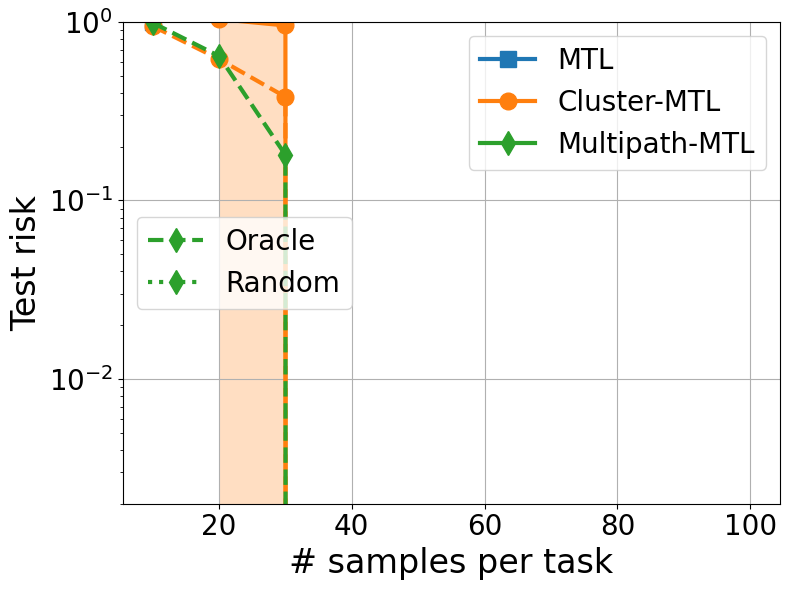

In [ ]:
mrk=['s','o','d']
labels=['MTL','Cluster-MTL','Multipath-MTL']
labels2=['Oracle','Random']
ls=[]
plt.figure(figsize=(8,6))
ax = plt.gca()
# ns = ns[:10]
for i in range(3):
    color = next(ax._get_lines.prop_cycler)['color']
    l,=plt.semilogy(ns,quant(ERRn[:,:,0,1,i],0.5),'-'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
    ls.append(l)
    # plt.semilogy(ns,quant(ERRn[:,:,0,0,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
    if i >0:
        s1,=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
        s2,=plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
    # if i == 2:
    #     s1=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
    #     plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
    plt.fill_between(ns,quant(ERRn[:,:,0,1,i],0.25),quant(ERRn[:,:,0,1,i],0.75),alpha=0.25)
plt.ylim([0.002,1])
# plt.xlim([0,20])
# plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
legend1=plt.legend([s1,s2],labels2,fontsize=20,loc='center left')
plt.legend(ls,labels,fontsize=20)
plt.gca().add_artist(legend1)
# plt.legend(labels2,fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('# samples per task',fontsize=24)
plt.ylabel('Test risk',fontsize=24)
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig('clusterring_sample_per_task_pinv.pdf')

# plt.figure(figsize=(8,6))
# ax = plt.gca()
# for i in range(3):
#     color = next(ax._get_lines.prop_cycler)['color']
#     l,=plt.semilogy(ks,quant(ERRk[:,:,0,1,i],0.5),'-'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
#     ls.append(l)
#     # plt.semilogy(ns,quant(ERRn[:,:,0,0,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels[i])
#     if i >0:
#         s1,=plt.semilogy(ks,quant(ERRk[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
#         s2,=plt.semilogy(ks,quant(ERRk[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
#     # if i == 2:
#     #     s1=plt.semilogy(ns,quant(ERRn[:,:,1,1,i],0.5),'--'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[0])
#     #     plt.semilogy(ns,quant(ERRn[:,:,2,1,i],0.5),':'+mrk[i],linewidth=3,markersize=12,color=color,label=labels2[1])
#     plt.fill_between(ks,quant(ERRk[:,:,0,1,i],0.25),quant(ERRk[:,:,0,1,i],0.75),alpha=0.25)
# # plt.ylim([0.002,1])
# # plt.xlim([0,50])
# # plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
# # plt.legend(fontsize=20)
# legend1=plt.legend([s1,s2],labels2,fontsize=20,loc='center left')
# plt.legend(ls,labels,fontsize=20)
# plt.gca().add_artist(legend1)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('# tasks per cluster',fontsize=24)
# plt.ylabel('Test risk',fontsize=24)
# plt.grid(True)
# plt.tight_layout()
# # plt.show()
# plt.savefig(f'clustering_task_per_cluster_{ITN}runs.pdf')

# plt.figure(figsize=(8,6))
# ax = plt.gca()
# for i in range(3):
#     color = next(ax._get_lines.prop_cycler)['color']
#     q=quant(ERRK[:,:,0,1,i],0.5); q2=q.copy()
#     q_=quant(ERRK[:,:,1,1,i],0.5); q2_=q_.copy()
#     #if i==1: q2[:1]=np.array([0.192])
#     plt.semilogy(Ks,q2,mrk[i]+'-',linewidth=4,markersize=12,color=color,label=labels[i])
#     plt.semilogy(Ks,q2_,mrk[i]+'--',linewidth=4,markersize=12,color=color)
#     plt.fill_between(Ks,quant(ERRK[:,:,0,1,i],0.25)+q2-q,quant(ERRK[:,:,0,1,i],0.75)+q2-q,alpha=0.25)
# # plt.ylim([0.002,1])
# # plt.xlim([0,150])
# # plt.legend(['MTL','Cluster-MTL','Multipath-MTL'],fontsize=20)
# plt.legend(fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.xlabel('# clusters',fontsize=24)
# plt.ylabel('Test risk',fontsize=24)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# # plt.savefig('cluster_fig.pdf')

In [ ]:
# ERRn=np.zeros((LEN,ITN,3,2,3))
ERRn_=[
    [
        # 10
        [0.9861322641372681, 1.2547764778137207, 1.327284574508667, 0.9408995509147644, 0.9980385899543762, 1.285880208015442, 1.2712531089782715],
        [0.9387074708938599, 1.2047901153564453, 1.2182780504226685, 0.9923163652420044, 1.0078344345092773, 1.2326558828353882, 1.2576197385787964],
        [1.0007461309432983, 1.2720986604690552, 1.3308907747268677, 0.9237116575241089, 0.9753985404968262, 1.2159618139266968, 1.2273142337799072],
        [1.0496890544891357, 1.281524658203125, 1.3306758403778076, 0.9227287173271179, 0.9795920252799988, 1.2283689975738525, 1.2910727262496948],
        [0.9545168876647949, 1.1755881309509277, 1.1896506547927856, 0.937301516532898, 0.958673357963562, 1.2238820791244507, 1.2321265935897827],
    ],
    [
        # 20
        [1.100624680519104, 1.0459396839141846, 1.0493665933609009, 0.5742796063423157, 0.7493282556533813, 1.0993726253509521, 1.103583812713623],
        [1.1323978900909424, 1.1196978092193604, 1.1418625116348267, 0.6239241361618042, 0.7647626399993896, 1.0820709466934204, 1.0999430418014526],
        [1.1254680156707764, 1.0906546115875244, 1.1135051250457764, 0.733902096748352, 0.7164332270622253, 1.1290050745010376, 1.1282832622528076],
        [1.1194747686386108, 1.0693492889404297, 1.1072841882705688, 0.6627336740493774, 0.7748873233795166, 1.0697728395462036, 1.0899593830108643],
        [1.0711801052093506, 1.0739535093307495, 1.098497748374939, 0.6580096483230591, 0.7672678828239441, 1.1481244564056396, 1.1656817197799683],
    ],
    [
        # 30
        [6.574476718902588, 1.0487695932388306, 1.0526280403137207, 0.5365959405899048, 0.4111834168434143, 1.0342060327529907, 1.0413150787353516],
        [8.136819839477539, 1.0595756769180298, 1.0586081743240356, 0.4413701891899109, 0.4520905911922455, 1.0466266870498657, 1.050997018814087],
    ],
    [
        # 50 new
        [0.2615366578102112, 0.5012065768241882, 0.030053267255425453, 0.4772440791130066, 0.005865814164280891, 0.9918482899665833, 0.9882580041885376]
    ],
    [
        # 70 new
        [0.00044255255488678813, 0.17888402938842773, 0.007833089679479599, 0.12193052470684052, 1.856822200352326e-05, 0.9809029698371887, 0.8334168195724487],
        [0.0004180484393145889, 0.08273537456989288, 0.010807810351252556, 0.06299391388893127, 1.7933793060365133e-05],
    ],
    [   
        # 90 new
        [4.66764068e-05, 1.81198083e-02, 6.45224145e-03, 5.68057001e-02, 4.58393333e-06, 9.88405049e-01, 7.14933515e-01]
    ]
]

In [ ]:
ERRn_noise = 
[
    [
        # 70
        [0.016640659421682358, 0.2399466335773468, 0.013167494907975197, 0.17404648661613464, 0.011176158674061298, ]
    ]
    [
        # 90
        [0.012577091343700886, 0.046353552490472794, 0.010321707464754581, 0.02343956008553505, 0.009294986724853516, 1.0010273456573486, 0.742176353931427],
    ]
]

SyntaxError: invalid syntax (<ipython-input-16-8f0bbb630950>, line 1)